In [ ]:
# TODOs:
# x Gaussian weights init
# x lr scheduling
# x D update mechanism using G pred history 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import os
import glob
import random
import itertools
import numpy as np
import PIL
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("/gdrive/MyDrive/Exploration-Space/GAN_study")


# Reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
# torch.set_deterministic(True)
# torch.backends.cudnn.deterministic = True

In [ ]:
WORKING_DIR = "/gdrive/MyDrive/Exploration-Space/GAN_study"
DATA_DIR = f"{WORKING_DIR}/horse2zebra"


# Correction -- Ignoring grayscale images 
IMAGES_TO_IGNORE = ["n02391049_8008.jpg", "n02391049_2341.jpg", "n02391049_9726.jpg", "n02391049_2757.jpg",
                    "n02391049_226.jpg", "n02391049_7503.jpg", "n02391049_2361.jpg"]

# Intensity statistics for normalization
CHANNEL_WISE_MEANS = {'trainA': [134.28, 132.29, 116.79], 'trainB': [123.26, 119.16, 101.17], 
                      'testA': [133.57, 133.71, 119.42], 'testB': [122.92, 119.5, 101.81]}
                      
CHANNEL_WISE_STDDEVS = {'trainA': [51.90, 52.55, 56.29], 'trainB': [59.02, 57.26, 55.80], 
                        'testA': [52.18, 53.11, 57.61], 'testB': [58.97, 57.51, 56.70]}

### 1 Data analysis

In [ ]:
def explore_data_subset(data_dir, subset='testA'):
  """
  Print #images, image size distribution
  """
  print("Data subset: ", subset)
  filenames = os.listdir(f"{data_dir}/{subset}")
  image_sizes = {}
  ch_wise_means = []
  ch_wise_stddevs = []
  print("Reading images ...")
  for filename in tqdm(filenames):
    image = PIL.Image.open(f"{data_dir}/{subset}/{filename}")
    image = np.array(image) # (W,H,C) format
    if str(image.shape) not in image_sizes.keys():
      image_sizes[str(image.shape)] = 1
    else:
      image_sizes[str(image.shape)] += 1
  
    if image.shape != (256,256,3):
      print("Image with non-standard size: ", filename)
  
    else: 
      ch_wise_means.append(np.mean(image, axis=(0,1)))
      ch_wise_stddevs.append(np.std(image, axis=(0,1)))
  
  print("-- Summary --")
  print("# Images: ", len(filenames))
  print("Image size statistics: ", image_sizes)
  print("Channel-wise mean: ", np.array(ch_wise_means).mean(axis=0))
  print("Channel-wise stddev: ", np.array(ch_wise_stddevs).mean(axis=0))

In [ ]:
# explore_data_subset(DATA_DIR, subset='trainA')
# explore_data_subset(DATA_DIR, subset='trainB')
# explore_data_subset(DATA_DIR, subset='testA')
# explore_data_subset(DATA_DIR, subset='testB')

## 2 Dataset class

In [ ]:
class HorseToZebraDataset(Dataset):
  """
  Domain A - Horses
  Domain B - Zebras
  Image sizes (W,H,C) - (256, 256, 3)
  """
  def __init__(self, data_dir, mode='train', norm_method='min-max'):
    super().__init__()
    self.data_dir = data_dir
    self.mode = mode
    self.filepaths_A = glob.glob(f"{self.data_dir}/{self.mode}A/*.jpg")
    self.filepaths_B = glob.glob(f"{self.data_dir}/{self.mode}B/*.jpg")
    self.norm_method = norm_method

    # Correction 
    for fp_B in self.filepaths_B:
      for im_name in IMAGES_TO_IGNORE:
        if im_name in fp_B:  self.filepaths_B.remove(fp_B)

    if self.mode == 'train':
      self.transform = transforms.Compose([
                                          transforms.RandomRotation(degrees=(-10, 10), resample=PIL.Image.BILINEAR),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor(),
                                          ])
    elif self.mode == 'test':
      self.transform = transforms.Compose([transforms.ToTensor()])
      
  
  def __len__(self):
    return min(len(self.filepaths_A), len(self.filepaths_B))

  def __getitem__(self, idx):
    idx_A = idx
    idx_B = idx

    # Shuffle one filepaths list to break A-B correspondences
    if self.mode == 'train':
      idx_B = random.randint(0, len(self.filepaths_B)-1)

    # Read images
    image_A = PIL.Image.open(self.filepaths_A[idx_A])  # PIL Image size format: (W,H)
    image_B = PIL.Image.open(self.filepaths_B[idx_B])

    # Transform (includes rescaling to [0,1])
    image_A = self.transform(image_A)   # Tensor size format: (C, H, W)
    image_B = self.transform(image_B)
    
    # Normalization transform
    image_A = self.normalize(image_A, domain='A')
    image_B = self.normalize(image_B, domain='B')
    
    # Construct sample dictionary
    sample = {'A': image_A,
              'B': image_B}
    return sample
  
  
  def normalize(self, image, domain):
    if self.norm_method == 'z-score':
      # Convert mean and stddev values from [0,255] scale to [0,1] scale
      channel_wise_mean = torch.tensor(CHANNEL_WISE_MEANS[f"{self.mode}{domain}"]).float() / 255.0
      channel_wise_stddev = torch.tensor(CHANNEL_WISE_STDDEVS[f"{self.mode}{domain}"]).float() / 255.0

      channel_wise_mean = torch.unsqueeze(torch.unsqueeze(channel_wise_mean, dim=1), dim=1)
      channel_wise_stddev = torch.unsqueeze(torch.unsqueeze(channel_wise_stddev, dim=1), dim=1)

      normalized_image = (image - channel_wise_mean) / channel_wise_stddev
    
    elif self.norm_method == 'min-max':
      normalized_image = image*2 - 1 # [0,1] scale -> [-1,1] scale

    return normalized_image

1067
120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.8431) tensor(1.)


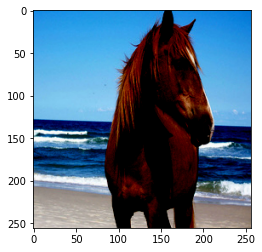

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.) tensor(1.)


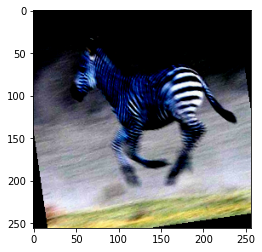

In [ ]:
# Unit testing - Dataset class

dataset_train = HorseToZebraDataset(DATA_DIR, mode='train', norm_method='min-max')
dataset_val = HorseToZebraDataset(DATA_DIR, mode='test', norm_method='min-max')

print(len(dataset_train))
print(len(dataset_val))

sample = dataset_train[0]
print(sample['A'].min(), sample['A'].max())
plt.imshow(sample['A'].permute(1,2,0))
plt.show()
print(sample['B'].min(), sample['B'].max())
plt.imshow(sample['B'].permute(1,2,0))
plt.show()


## 3 NN classes

In [ ]:
class Generator(nn.Module):
  """
  Same model architecture as used in the CycleGAN paper, which in turn adopts from Neural Style Transfer paper.
  Some modifications are made in implementation.
  """
  def __init__(self):
    super().__init__()
    
    conv_blocks = [DownConvBlock(in_channels=3, out_channels=64, kernel_size=7, stride=1, 
                                 padding=3, padding_mode='reflect', norm='instance', activation='relu'),
                   DownConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=2, 
                                 padding=1, padding_mode='reflect', norm='instance', activation='relu'),
                   DownConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=2, 
                                 padding=1, padding_mode='reflect', norm='instance', activation='relu')]
    
    residual_blocks = [ResidualBlock() for _ in range(9)]
    
    upconv_blocks = [UpConvBlock(in_channels=256, out_channels=128, kernel_size=3, stride=2, 
                                 padding=1, output_padding=1, padding_mode='zeros', norm='instance'),
                     UpConvBlock(in_channels=128, out_channels=64, kernel_size=3, stride=2, 
                                 padding=1, output_padding=1, padding_mode='zeros', norm='instance')]
    
    final_block = DownConvBlock(in_channels=64, out_channels=3, kernel_size=7, stride=1, 
                                padding=3, padding_mode='reflect', norm=None, activation=None)
    
    self.generator = nn.Sequential(*conv_blocks, *residual_blocks, *upconv_blocks, final_block, nn.Tanh())

  def forward(self, x):
    return self.generator(x)


class Discriminator(nn.Module):
  """
  PatchGAN architecture as used in the CycleGAN paper. 
  Patch size - 70 x 70 -- i.e. for a patch of size (70,70) it decides whether real or fake.
  Implemented here in a fully convolutional manner -- i.e. for size (256,256) it produces a spatial map of decision probs.
  """
  def __init__(self):
    super().__init__()
    conv_blocks = [DownConvBlock(in_channels=3, out_channels=64, kernel_size=4, stride=2, 
                                 padding=0, norm=None, activation='leaky-relu'),
                   DownConvBlock(in_channels=64, out_channels=128, kernel_size=4, stride=2, 
                                 padding=0, norm='instance', activation='leaky-relu'),
                   DownConvBlock(in_channels=128, out_channels=256, kernel_size=4, stride=2, 
                                 padding=0, norm='instance', activation='leaky-relu'),
                   DownConvBlock(in_channels=256, out_channels=512, kernel_size=4, stride=2, 
                                 padding=0, norm='instance', activation='leaky-relu')]
    
    final_layer = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=2, stride=2)
    
    self.discriminator = nn.Sequential(*conv_blocks, final_layer, nn.Sigmoid())

  def forward(self, x):
    prob_map = self.discriminator(x)
    decision = prob_map.mean(dim=(2,3))
    # print(decision.shape)
    return decision


class ResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_block_1 = DownConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, 
                                      padding=1, padding_mode='reflect', norm='instance', activation='relu')
    
    self.conv_block_2 = DownConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, 
                                      padding=1, padding_mode='reflect', norm='instance', activation=None)
  
  def forward(self, x_in):
    x = self.conv_block_1(x_in)
    x = self.conv_block_2(x)
    x_out = x + x_in
    return x_out


class DownConvBlock(nn.Module):
  """
  2D convolution block
  """
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, padding_mode='zeros', norm='instance', activation='relu'):
    super().__init__()
    layers = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, 
                        padding=padding, padding_mode=padding_mode)]
  
    if norm == 'instance':
      layers.append(nn.InstanceNorm2d(out_channels))

    if activation == 'relu':
      layers.append(nn.ReLU())
    elif activation == 'leaky-relu':
      layers.append(nn.LeakyReLU(negative_slope=0.2))

    self.conv_block = nn.Sequential(*layers)

  def forward(self, x):
    return self.conv_block(x)


class UpConvBlock(nn.Module):
  """
  2D transpose convolution block
  Note: Only padding_mode='zeros' supported by Pytorch in nn.ConvTranspose2d() module currently
  """
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, padding_mode='zeros', norm='instance'):
    super().__init__()
    layers = [nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, 
                                 padding=padding, output_padding=output_padding, padding_mode=padding_mode)]

    if norm == 'instance':      
      layers.append(nn.BatchNorm2d(out_channels))
              
    self.upconv_block = nn.Sequential(*layers, nn.ReLU())

  def forward(self, x):
    return self.upconv_block(x)

In [ ]:
# Unit testing

## Generator
generator = Generator().cuda()
x = torch.zeros(1,3,256,256).cuda()
out = generator(x)
print(out.shape)

## Discriminator
discriminator = Discriminator().cuda()
x = torch.zeros(4,3,256,256).cuda()
out = discriminator(x)
print(out.shape)


torch.Size([1, 3, 256, 256])
torch.Size([4, 1])


## 4 Loss function classes

In [ ]:
class AdversarialLoss(nn.Module):
  """
  Adversarial loss from CycleGAN paper
  Least squares loss used, instead of log-likelihood loss -- see CycleGAN paper (Section 4)
  """
  def __init__(self):
    super().__init__()
    self.mse_loss = nn.MSELoss(reduction='mean')
  
  def forward(self, preds, labels):
    preds = preds.float()
    labels = labels.float()
    adv_loss = self.mse_loss(preds, labels)
    return adv_loss

class CycleConsistencyLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1_loss = nn.L1Loss(reduction='mean')
  
  def forward(self, x_A_recon, x_A_real, x_B_recon, x_B_real):    
    recon_loss_A = self.l1_loss(x_A_recon, x_A_real)
    recon_loss_B = self.l1_loss(x_B_recon, x_B_real)
    cycle_loss = recon_loss_A + recon_loss_B
    return cycle_loss

In [ ]:
# Unit testing

## Adversarial loss
adv_criterion = AdversarialLoss()
labels = torch.tensor([[1.0], 
                       [1.0]])
preds = torch.tensor([[1.0], 
                      [1.0]])
print(adv_criterion(preds, labels))

## Cycle loss
cyc_criterion = CycleConsistencyLoss()
x_A_real = torch.rand(1,3,256,256)
x_A_recon = x_A_real.detach().clone()
x_B_real = torch.rand(1,3,256,256)
x_B_recon = x_B_real.detach().clone()
print(cyc_criterion(x_A_recon, x_A_real, x_B_recon, x_B_real))

tensor(0.)
tensor(0.)


## 5 Config and Initialization

In [ ]:
# Training config -- see CycleGAN paper (Section 7)

n_epochs = 200
device = 'cuda'

batch_size = 4
norm_method = 'min-max'

cycle_loss_weight = 10
D_loss_weight = 0.5   # To conrol the rate of D's learning relative to G's
optim_config = {'lr': 0.0002}
decay_start_epoch = 110
max_buffer_size = 48

load_from_checkpoint = True
checkpoint_load_path = f"{WORKING_DIR}/checkpoints/saved_state-e165.pt"

In [ ]:
# Data pipeline init

## Training 
dataset_train = HorseToZebraDataset(data_dir=DATA_DIR, mode='train', norm_method=norm_method)
dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

## Validation   
dataset_val = HorseToZebraDataset(data_dir=DATA_DIR, mode='test', norm_method=norm_method)
dataloader_val = DataLoader(dataset_val, batch_size=4, num_workers=4, drop_last=True)


In [ ]:
# Model init, save, load utils

def init_state(models, optim_config):
  # Models
  for nn_name in models.keys():
    for p in models[nn_name].parameters():
      torch.nn.init.normal_(p, mean=0.0, std=0.02)

  # Optimizers  
  optimizers = {
  'G': Adam(itertools.chain(models['G_BA'].parameters(), models['G_AB'].parameters()), 
            lr=optim_config['lr']),
  'D_A': Adam(models['D_A'].parameters(), lr=optim_config['lr']),
  'D_B': Adam(models['D_B'].parameters(), lr=optim_config['lr'])
               }

  # Start epoch
  start_epoch = 1
  
  return models, optimizers, start_epoch


def load_state(models, optim_config, checkpoint_laod_path):
  checkpoint_dict = torch.load(checkpoint_laod_path)
  
  # Models
  for nn_name in models.keys():
    models[nn_name].load_state_dict(checkpoint_dict[f'model-{nn_name}'])
  
  # Optimizers
  optimizers = {
  'G': Adam(itertools.chain(models['G_BA'].parameters(), models['G_AB'].parameters()), 
            lr=optim_config['lr']),
  'D_A': Adam(models['D_A'].parameters(), lr=optim_config['lr']),
  'D_B': Adam(models['D_B'].parameters(), lr=optim_config['lr'])
               }
  optimizers['G'].load_state_dict(checkpoint_dict['optimizer-G'])
  optimizers['D_A'].load_state_dict(checkpoint_dict['optimizer-D_A'])
  optimizers['D_B'].load_state_dict(checkpoint_dict['optimizer-D_B'])

  # Start epoch
  start_epoch = checkpoint_dict['epoch'] + 1

  return models, optimizers, start_epoch


def save_state(models, optimizers, epoch, checkpoint_save_path):
  checkpoint_dict = {
                    'epoch': epoch,
                    'model-G_BA': models['G_BA'].state_dict(), 'model-D_A': models['D_A'].state_dict(),
                    'model-G_AB': models['G_AB'].state_dict(), 'model-D_B': models['D_B'].state_dict(),
                    'optimizer-G': optimizers['G'].state_dict(), 
                    'optimizer-D_A': optimizers['D_A'].state_dict(), 'optimizer-D_B': optimizers['D_B'].state_dict()
                    }
  torch.save(checkpoint_dict, checkpoint_save_path)


class LRLambdaClass():
  def __init__(self, n_epochs, start_epoch, decay_start_epoch):
    self.n_epochs = n_epochs
    self.start_epoch = start_epoch
    self.decay_start_epoch = decay_start_epoch

  def step(self, epoch):
    lr_multiplier = 1.0 - max(0, epoch + self.start_epoch - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)
    # print(epoch, '--', lr_multiplier)
    return lr_multiplier

In [ ]:
# Models, optimizers and LR schedulers init

"""
Data structure of models and optimizers --
  - models = {'G_BA': Generator(), 'D_A': Discriminator(),
              'G_AB': Generator(), 'D_B': Discriminator()}
  - optimizers = {'G': Adam(), 'D_A': Adam(), 'D_B': Adam()}   # i.e. No. of optimizers = No. of losses back-prop'd
  - lr_schedulers = {'G': LambdaLR(), 'D_A': LambdaLR(), 'D_B': LambdaLR()}
"""

## NN and optimizers
models = {'G_BA': Generator().to(device),
          'D_A': Discriminator().to(device),
          'G_AB': Generator().to(device),
          'D_B': Discriminator().to(device)}

if load_from_checkpoint:
  print(f"Loading checkpoint: {checkpoint_load_path}")
  models, optimizers, start_epoch = load_state(models, optim_config, checkpoint_load_path)
else:
  print("Initializing model parameters")
  models, optimizers, start_epoch = init_state(models, optim_config)

## LR schedulers
lr_schedulers = {}
lr_schedulers['G'] = torch.optim.lr_scheduler.LambdaLR(optimizers['G'], 
                                                      lr_lambda=LRLambdaClass(n_epochs, start_epoch, decay_start_epoch).step)
lr_schedulers['D_A'] = torch.optim.lr_scheduler.LambdaLR(optimizers['D_A'], 
                                                      lr_lambda=LRLambdaClass(n_epochs, start_epoch, decay_start_epoch).step)
lr_schedulers['D_B'] = torch.optim.lr_scheduler.LambdaLR(optimizers['D_B'], 
                                                      lr_lambda=LRLambdaClass(n_epochs, start_epoch, decay_start_epoch).step)

## Losses
adv_criterion = AdversarialLoss()
cycle_criterion = CycleConsistencyLoss()


Loading checkpoint: /gdrive/MyDrive/Exploration-Space/GAN_study/checkpoints/saved_state-e165.pt


In [ ]:
# Checks
assert max_buffer_size % batch_size//2 == 0
assert start_epoch < n_epochs

## 6 GAN training

In [ ]:
# Training utils

def push_to_buffer(buffer, tensor_batch, n_samples):
  """
  Push specified number of samples into buffer
  """
  buffer.extend([tensor_batch[i, :, :, :] for i in range(n_samples)])
  return buffer 

def pop_from_buffer(buffer, n_samples):
  """
  Randomly pop samples from the buffer 
  """
  idxs = list(range(len(buffer) - 1))
  random.shuffle(idxs)
  idxs = idxs[0:n_samples] 

  sampled_tensors = [buffer.pop(i) for i in idxs]
  tensor_batch = torch.stack(sampled_tensors, dim=0)
  return tensor_batch, buffer


def viz_losses(loss_history, start_epoch, save=True, path=f"{WORKING_DIR}/models/train_loss.png"):
  fig, [ax_G, ax_D] = plt.subplots(1, 2, figsize=(8, 4))
  ax_G.plot(np.arange(start_epoch, start_epoch+len(loss_history['L_G'])), loss_history['L_G'], label='Total G loss')
  ax_G.set_xlabel("epoch")
  ax_G.legend()

  ax_D.plot(np.arange(start_epoch, start_epoch+len(loss_history['L_adv_D_B'])), loss_history['L_adv_D_B'], label='D_B loss')
  ax_D.plot(np.arange(start_epoch, start_epoch+len(loss_history['L_adv_D_A'])), loss_history['L_adv_D_A'], label='D_A loss')
  ax_D.set_xlabel("epoch")
  ax_D.legend()

  fig.tight_layout()  
  if save:
    plt.savefig(path)
  plt.show()

def viz_images(x_A_real_stack, x_B_real_stack, x_A_fake_stack, x_B_fake_stack, n_images=32,
               save=True, path=f"{WORKING_DIR}/models/train_loss.png"):
  x_A_real_stack = (x_A_real_stack[0:n_images, :, :, :] + 1) / 2
  x_B_real_stack = (x_B_real_stack[0:n_images, :, :, :] + 1) / 2 
  x_A_fake_stack = (x_A_fake_stack[0:n_images, :, :, :] + 1) / 2 
  x_B_fake_stack = (x_B_fake_stack[0:n_images, :, :, :] + 1) / 2
  
  fig, [[ax_A, ax_AB], [ax_B, ax_BA]] = plt.subplots(2, 2, figsize=(16, 10))

  grid = torchvision.utils.make_grid(x_A_real_stack.cpu().detach(), nrow=8)
  ax_A.imshow(grid.permute(1,2,0))
  ax_A.set_title("A")

  grid = torchvision.utils.make_grid(x_B_fake_stack.cpu().detach(), nrow=8)
  ax_AB.imshow(grid.permute(1,2,0))
  ax_AB.set_title("A -> B")

  grid = torchvision.utils.make_grid(x_B_real_stack.cpu().detach(), nrow=8)
  ax_B.imshow(grid.permute(1,2,0))
  ax_B.set_title("B")

  grid = torchvision.utils.make_grid(x_A_fake_stack.cpu().detach(), nrow=8)
  ax_BA.imshow(grid.permute(1,2,0))
  ax_BA.set_title("B -> A")

  for ax in [ax_A, ax_AB, ax_B, ax_BA]:  ax.axis('off')
  fig.tight_layout()
  if save:
    plt.savefig(path)
  plt.show()


In [ ]:
ZEROS = torch.zeros(batch_size, 1, requires_grad=False).to(device)
ONES = torch.ones(batch_size, 1, requires_grad=False).to(device)


# Training loop
train_loss_history = {'L_G': [], 'L_adv_D_A': [], 'L_adv_D_B': []}
val_loss_history = {'L_G': [], 'L_adv_D_A': [], 'L_adv_D_B': []}
fake_A_buffer, fake_B_buffer  = [], []

for epoch in range(start_epoch, n_epochs+1):
  print(f"\n-- EPOCH: {epoch} --")
  L_G_train_epoch, L_adv_D_A_train_epoch, L_adv_D_B_train_epoch = 0, 0, 0
  L_G_val_epoch, L_adv_D_B_val_epoch, L_adv_D_A_val_epoch = 0, 0, 0
    
 # Train ----------------------------------------------------------------------
  print("Training ...")
  for batch in tqdm(dataloader_train):
    # Fetch data
    x_A_real = batch['A'].to(device)
    x_B_real = batch['B'].to(device)

    # ----------------------------
    # Train Generators G_BA and G_AB
    models['G_BA'].train()
    models['G_AB'].train()
    optimizers['G'].zero_grad()

    ## G_AB adversavial loss
    x_B_fake = models['G_AB'](x_A_real)
    L_adv_G_AB = adv_criterion(models['D_B'](x_B_fake), ONES)
      
    ## G_BA adversarial loss
    x_A_fake = models['G_BA'](x_B_real)
    L_adv_G_BA = adv_criterion(models['D_A'](x_A_fake), ONES)

    ## Cycle loss
    x_A_recon = models['G_BA'](x_B_fake)
    x_B_recon = models['G_AB'](x_A_fake)
    L_cycle = cycle_criterion(x_A_recon, x_A_real, x_B_recon, x_B_real)

    ## Combined generator loss
    L_G = L_adv_G_AB + L_adv_G_BA + cycle_loss_weight*L_cycle
    L_G.backward()
    optimizers['G'].step()

    models['G_BA'].eval()
    models['G_AB'].eval()
    
    # Add fake images into history buffers
    if len(fake_A_buffer) < max_buffer_size: 
      fake_A_buffer = push_to_buffer(fake_A_buffer, x_A_fake.detach(), n_samples=batch_size//2)
      fake_B_buffer = push_to_buffer(fake_B_buffer, x_B_fake.detach(), n_samples=batch_size//2)


    # ---------
    # Train D_B 
    optimizers['D_B'].zero_grad()

    if len(fake_B_buffer) >= max_buffer_size: 
      x_B_fake_curr = x_B_fake.detach()[0:batch_size//2, :, :, :]
      x_B_fake_past, fake_B_buffer = pop_from_buffer(fake_B_buffer, n_samples=batch_size//2)
      L_adv_D_B_fake = adv_criterion(models['D_B'](x_B_fake_curr), ZEROS[0:batch_size//2, :]) + \
                       adv_criterion(models['D_B'](x_B_fake_past), ZEROS[0:batch_size//2, :])
    else:
      L_adv_D_B_fake = adv_criterion(models['D_B'](x_B_fake.detach()), ZEROS)

    L_adv_D_B_real = adv_criterion(models['D_B'](x_B_real), ONES)
    L_adv_D_B = D_loss_weight * 0.5 * (L_adv_D_B_fake + L_adv_D_B_real)
    
    L_adv_D_B.backward()
    optimizers['D_B'].step()

    # ---------
    # Train D_A 
    optimizers['D_A'].zero_grad()

    if len(fake_A_buffer) >= max_buffer_size: 
      x_A_fake_curr = x_A_fake.detach()[0:batch_size//2, :, :, :]
      x_A_fake_past, fake_A_buffer = pop_from_buffer(fake_A_buffer, n_samples=batch_size//2)
      L_adv_D_A_fake = adv_criterion(models['D_A'](x_A_fake_curr), ZEROS[0:batch_size//2, :]) + \
                       adv_criterion(models['D_A'](x_A_fake_past), ZEROS[0:batch_size//2, :])
    else: 
      L_adv_D_A_fake = adv_criterion(models['D_A'](x_A_fake.detach()), ZEROS)

    L_adv_D_A_real = adv_criterion(models['D_A'](x_A_real), ONES)
    L_adv_D_A = D_loss_weight * 0.5 * (L_adv_D_A_fake + L_adv_D_A_real)

    L_adv_D_A.backward()
    optimizers['D_A'].step()

    # ------------------
    # Accumulate results
    L_G_train_epoch += L_G.item()
    L_adv_D_B_train_epoch += L_adv_D_B.item()
    L_adv_D_A_train_epoch += L_adv_D_A.item()

    # ----------------
    # Clear cuda cache
    torch.cuda.empty_cache()
    
    # break

  # -------------------
  # Epoch train results 
  train_loss_history['L_G'].append(L_G_train_epoch / len(dataloader_train))
  train_loss_history['L_adv_D_B'].append(L_adv_D_B_train_epoch / len(dataloader_train))
  train_loss_history['L_adv_D_A'].append(L_adv_D_A_train_epoch / len(dataloader_train))


  # Validate -------------------------------------------------------------------
  x_A_real_stack, x_B_real_stack, x_A_fake_stack, x_B_fake_stack = [], [], [], []

  print("Validating ...")
  for batch in tqdm(dataloader_val):
    # Fetch data
    x_A_real = batch['A'].to(device)
    x_B_real = batch['B'].to(device)

    with torch.no_grad():
      # Translate
      x_B_fake = models['G_AB'](x_A_real)
      x_A_fake = models['G_BA'](x_B_real)

      # Compute cycle recons
      x_A_recon = models['G_BA'](x_B_fake)
      x_B_recon = models['G_AB'](x_A_fake)

      # Compute losses
      L_adv_G_AB = adv_criterion(models['D_B'](x_B_fake), ONES)
      L_adv_G_BA = adv_criterion(models['D_A'](x_A_fake), ONES)
      L_cycle = cycle_criterion(x_A_recon, x_A_real, x_B_recon, x_B_real)
      L_G = L_adv_G_AB + L_adv_G_BA + L_cycle

      L_adv_D_B = D_loss_weight * 0.5 * (adv_criterion(models['D_B'](x_B_fake.detach()), ZEROS) + \
                                         adv_criterion(models['D_B'](x_B_real), ONES))
      L_adv_D_A = D_loss_weight * 0.5 * (adv_criterion(models['D_A'](x_A_fake.detach()), ZEROS) + \
                                         adv_criterion(models['D_A'](x_A_real), ONES))

    # Clear cuda cache
    torch.cuda.empty_cache()
      
    # Accumulate
    L_G_val_epoch += L_G.item()
    L_adv_D_B_val_epoch += L_adv_D_B.item()
    L_adv_D_A_val_epoch += L_adv_D_A.item()

    x_A_real_stack.append(x_A_real)
    x_B_real_stack.append(x_B_real)
    x_A_fake_stack.append(x_A_fake)
    x_B_fake_stack.append(x_B_fake)

    # break

  val_loss_history['L_G'].append(L_G_val_epoch / len(dataloader_val))
  val_loss_history['L_adv_D_B'].append(L_adv_D_B_val_epoch / len(dataloader_val))
  val_loss_history['L_adv_D_A'].append(L_adv_D_A_val_epoch / len(dataloader_val))

  x_A_real_stack, x_B_real_stack, x_A_fake_stack, x_B_fake_stack = \
                    torch.cat(x_A_real_stack, dim=0), torch.cat(x_B_real_stack, dim=0), \
                    torch.cat(x_A_fake_stack, dim=0), torch.cat(x_B_fake_stack, dim=0)
  

  # Update LR ------------------------------------------------------------------
  lr_schedulers['G'].step()
  lr_schedulers['D_A'].step()
  lr_schedulers['D_B'].step()


  # Checkpoint and visualize ---------------------------------------------------
  # Checkpoint every 5 epochs
  if epoch % 5 == 0:
    checkpoint_save_path = f"{WORKING_DIR}/checkpoints/saved_state-e{epoch}.pt"
    save_state(models, optimizers, epoch, checkpoint_save_path)
    savefigs = True
  else:
    savefigs = False
  
  # Loss plots
  print("Training losses --")
  viz_losses(train_loss_history, start_epoch, save=savefigs, path=f"{WORKING_DIR}/checkpoints/train_loss-e{epoch}.png")
  print("Validation losses --")
  viz_losses(val_loss_history, start_epoch, save=savefigs, path=f"{WORKING_DIR}/checkpoints/val_loss-e{epoch}.png")

  # Viz images - display first 32 images
  print("Validation images")
  viz_images(x_A_real_stack, x_B_real_stack, x_A_fake_stack, x_B_fake_stack, n_images=32,
             save=savefigs, path=f"{WORKING_DIR}/checkpoints/val_samples-e{epoch}.png")

Output hidden; open in https://colab.research.google.com to view.